# Demo LoFTR-DS on a single pair of images

This notebook shows how to use the loftr matcher with default config(dual-softmax) and the pretrained weights.

In [13]:
%cd /home/anhalu/anhalu-data/junction_AITrack/Lam

/home/anhalu/anhalu-data/junction_AITrack/Lam


In [34]:
# Configure environment and grab LoFTR code.
!rm -rf sample_data
!pip install torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
!mv LoFTR/* . && rm -rf LoFTR

Cloning into 'LoFTR'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (142/142), done.
^Cceiving objects:   4% (7/173), 1.64 MiB | 103.00 KiB/s  
mv: cannot stat 'LoFTR/*': No such file or directory


In [12]:
import os
os.chdir("..")
from copy import deepcopy

import torch
import time
import cv2
import numpy as np
import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure

import gc
torch.cuda.empty_cache()
gc.collect()

22384

## Indoor Example

In [13]:
from src.loftr import LoFTR, default_cfg

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
_default_cfg = deepcopy(default_cfg)
_default_cfg['coarse']['temp_bug_fix'] = True  # set to False when using the old ckpt
matcher = LoFTR(config=_default_cfg)
matcher.load_state_dict(torch.load("/home/anhalu/anhalu-data/junction_AITrack/Lam/weights/outdoor_ds.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

In [14]:
# Load example images
# img0_pth = "assets/scannet_sample_images/scene0711_00_frame-001680.jpg"
# img1_pth = "assets/scannet_sample_images/scene0711_00_frame-001995.jpg"
img0_pth = "/home/anhalu/anhalu-data/junction_AITrack/phong3.png"
img1_pth = "/home/anhalu/anhalu-data/junction_AITrack/phong2.png"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
width = 480
height = 640
img0_raw = cv2.resize(img0_raw, (width, height))  # input size should be divisible by 8
img1_raw = cv2.resize(img1_raw, (width, height))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

start_time = time.time()
# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()
print(time.time() - start_time)

0.24398446083068848


In [15]:
# Draw
# color = cm.jet(mconf)
# text = [
#     'LoFTR',
#     'Matches: {}'.format(len(mkpts0)),
# ]
# fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)
hull0 = cv2.convexHull(mkpts0.astype(int))
hull1 = cv2.convexHull(mkpts1.astype(int))
hull_list0 = []
hull_list1 = []
for i in hull0:
    hull_list0.append(i)
for i in hull1:
    hull_list1.append(i)
cv2.polylines(img0_raw, hull_list0, isClosed=True, color=(255, 255, 255), thickness=2)
cv2.polylines(img1_raw, hull_list1, isClosed=True, color=(255, 255, 255), thickness=2)
cv2.imshow("Img0", img0_raw)
cv2.imshow("Img1", img1_raw)
cv2.waitKey(20000)
cv2.destroyAllWindows()

KeyboardInterrupt: 

## Outdoor Example

In [56]:
from src.loftr import LoFTR, default_cfg

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load("/home/anhalu/anhalu-data/junction_AITrack/Lam/weights/outdoor_ds.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

In [37]:
default_cfg['coarse']

{'d_model': 256,
 'd_ffn': 256,
 'nhead': 8,
 'layer_names': ['self',
  'cross',
  'self',
  'cross',
  'self',
  'cross',
  'self',
  'cross'],
 'attention': 'linear',
 'temp_bug_fix': False}

In [60]:
# Load example images
img0_pth = "/home/anhalu/anhalu-data/junction_AITrack/phong3.png"
img1_pth = "/home/anhalu/anhalu-data/junction_AITrack/phong2.png"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (img0_raw.shape[1]//8*8, img0_raw.shape[0]//8*8))  # input size should be divisible by 8
img1_raw = cv2.resize(img1_raw, (img1_raw.shape[1]//8*8, img1_raw.shape[0]//8*8))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

OutOfMemoryError: CUDA out of memory. Tried to allocate 242.00 MiB (GPU 0; 3.82 GiB total capacity; 2.91 GiB already allocated; 103.00 MiB free; 3.55 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

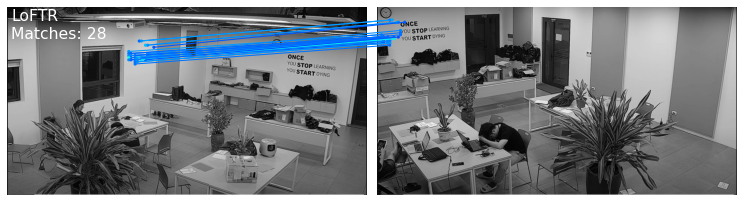

In [51]:
# Draw
color = cm.jet(mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)